In [1]:
## packages for data table processing 
library(here)
library(tidyverse)

## main Seurat package snRNA-seq pacakges
library(Seurat)
library(SeuratDisk)
library(future)

ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)

Warning message:
“package ‘here’ was built under R version 4.1.3”
here() starts at /projects/pfenninggroup/singleCell/Pierce_transgen_rat_multiome

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
── Co

In [2]:
#######################################################
# 0) Seurat uses the future package for parallelization
## set to be parallel over 12 cores
plan("multicore", workers = 4)
options(future.globals.maxSize = 100 * 1024^3)
options(future.rng.onMisuse = 'ignore')

In [3]:
##################################################
# 1) load in cell type labels for label transfer
## read in Logan BU snRNA dataset for label refinement
save_merged_fn = here('data/tidy_data/Seurat_projects', 
                        "Rat_transgen_multiomeRNA_filteredImputed_SeuratObj_N5.h5Seurat")
obj_merged = save_merged_fn %>% LoadH5Seurat() 


## read in the MSN dataset for label refinement
save_subset_msn = here('data/tidy_data/Seurat_projects', 
                        "Rat_transgen_multiomeRNA_filteredImputed_SeuratObj_subsetMSN_N5.h5Seurat")
obj_msn = save_subset_msn %>% LoadH5Seurat()

Validating h5Seurat file

Initializing MAGIC_RNA with data

Adding miscellaneous information for MAGIC_RNA

Initializing MAGIC_SCT with data

Adding miscellaneous information for MAGIC_SCT

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction harmony

Adding cell embeddings for harmony

Adding feature loadings for harmony

Adding projected loadings for harmony

Adding miscellaneous information for harmony

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding graph SCT_nn

Adding graph SCT_snn

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding 

In [4]:
###########################
# 2) Refine the MSN labels

## redo the clustering for the MSNs
obj_msn <- obj_msn %>% FindClusters(resolution = 1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10845
Number of edges: 389289

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8438
Number of communities: 21
Elapsed time: 1 seconds


Length of unique values greater than palette, interpolating..



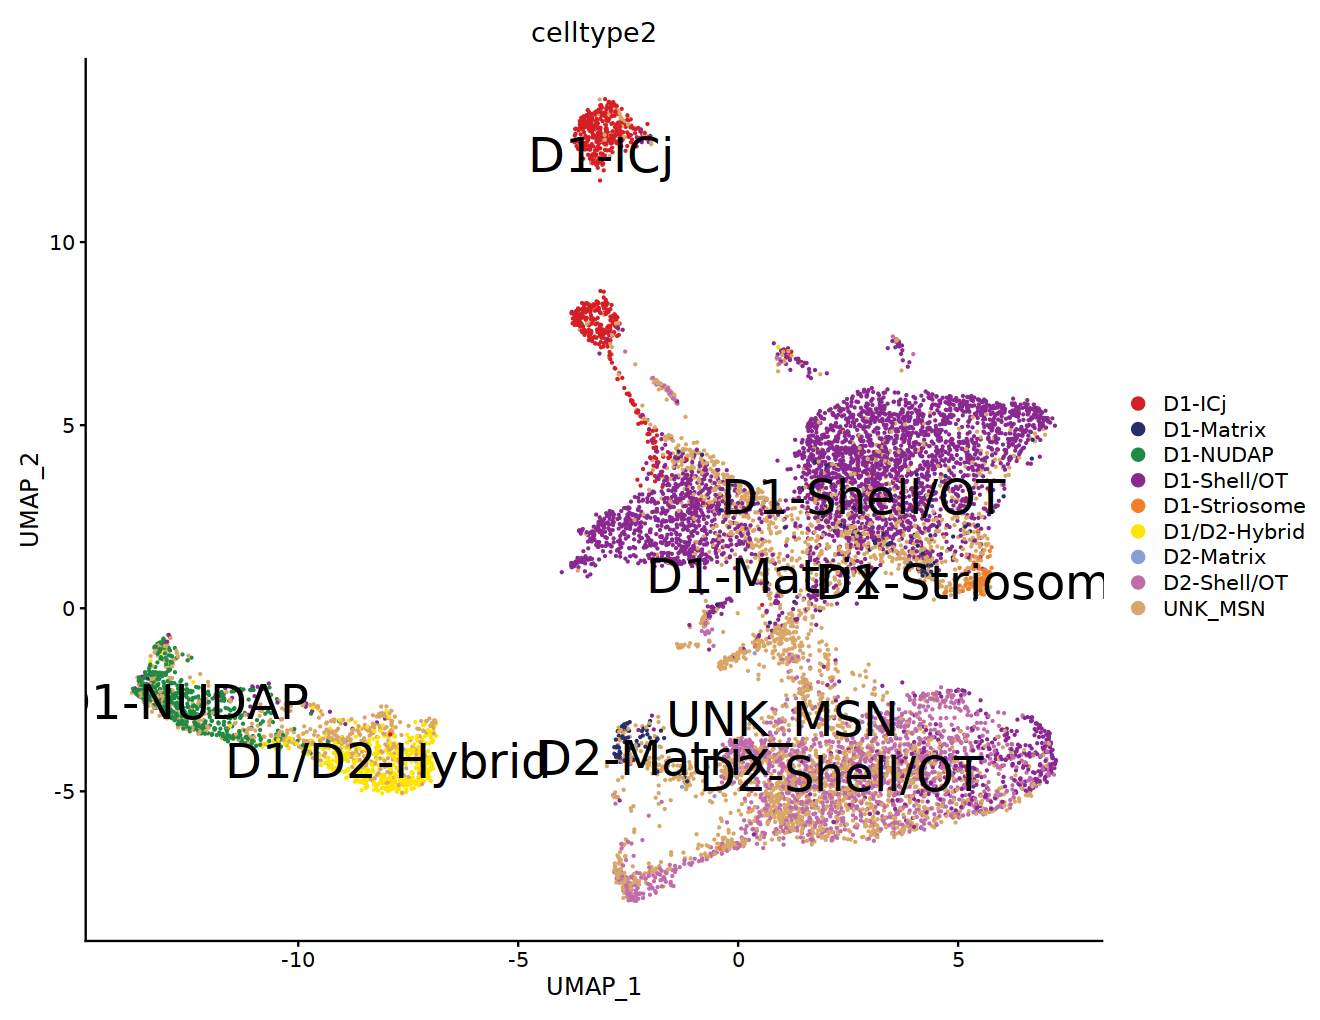

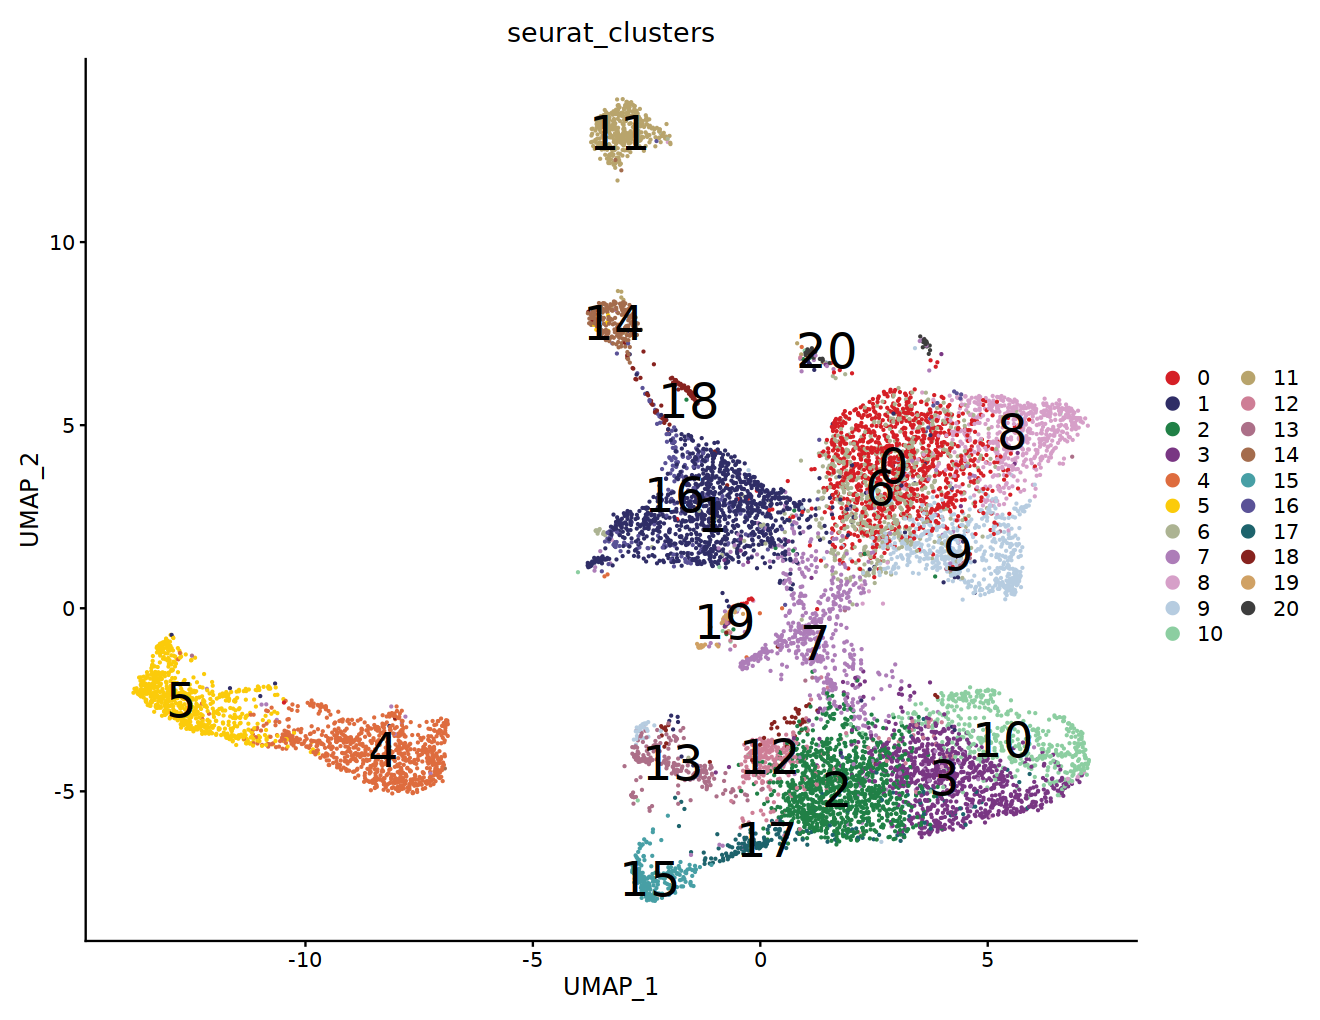

In [5]:
## plot the MSN sublabel
options(repr.plot.width=11, repr.plot.height=8.5)
DimPlot(obj_msn, reduction = "umap", group.by = "celltype2", label = TRUE, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_msn$celltype2)))
DimPlot(obj_msn, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 10, 
        cols = ArchR::paletteDiscrete(unique(obj_msn$seurat_clusters)))

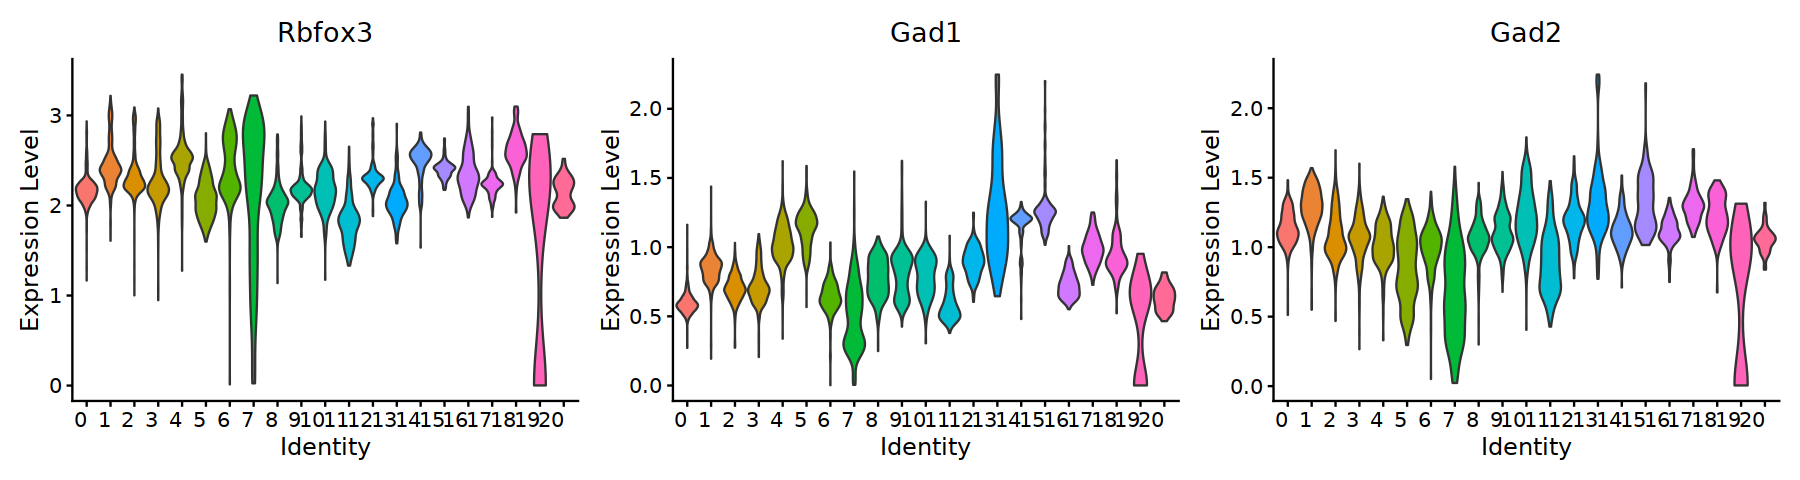

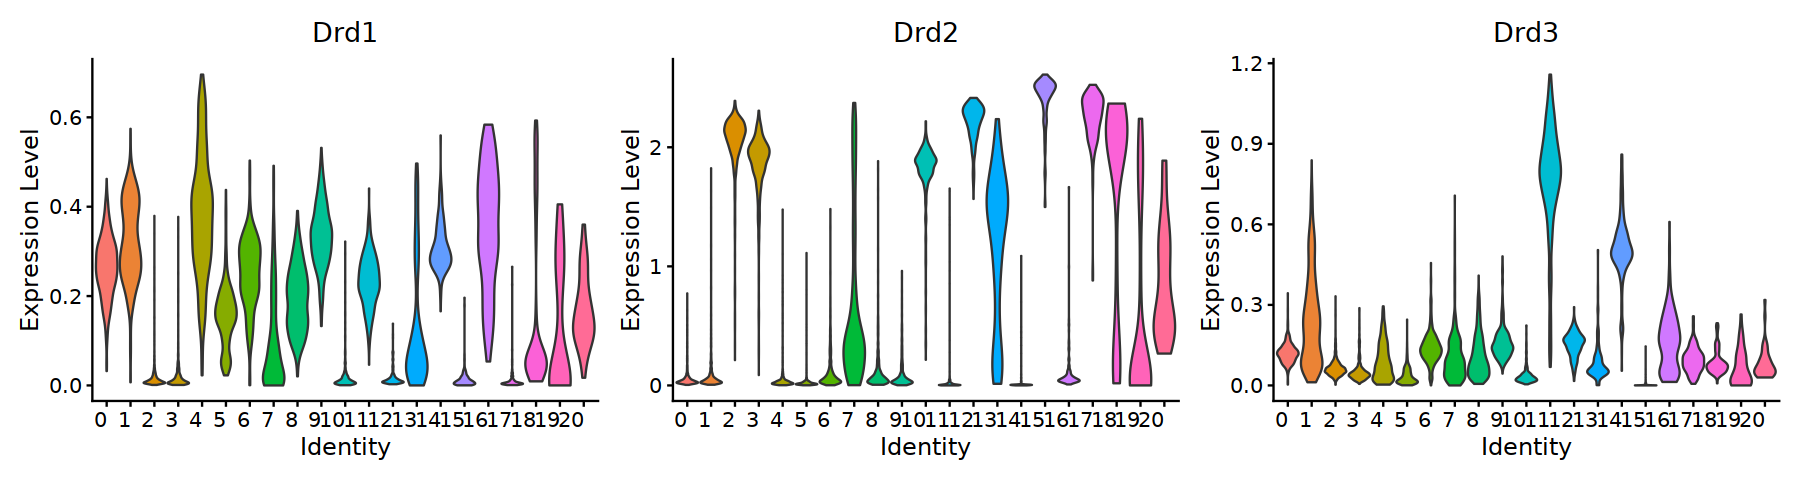

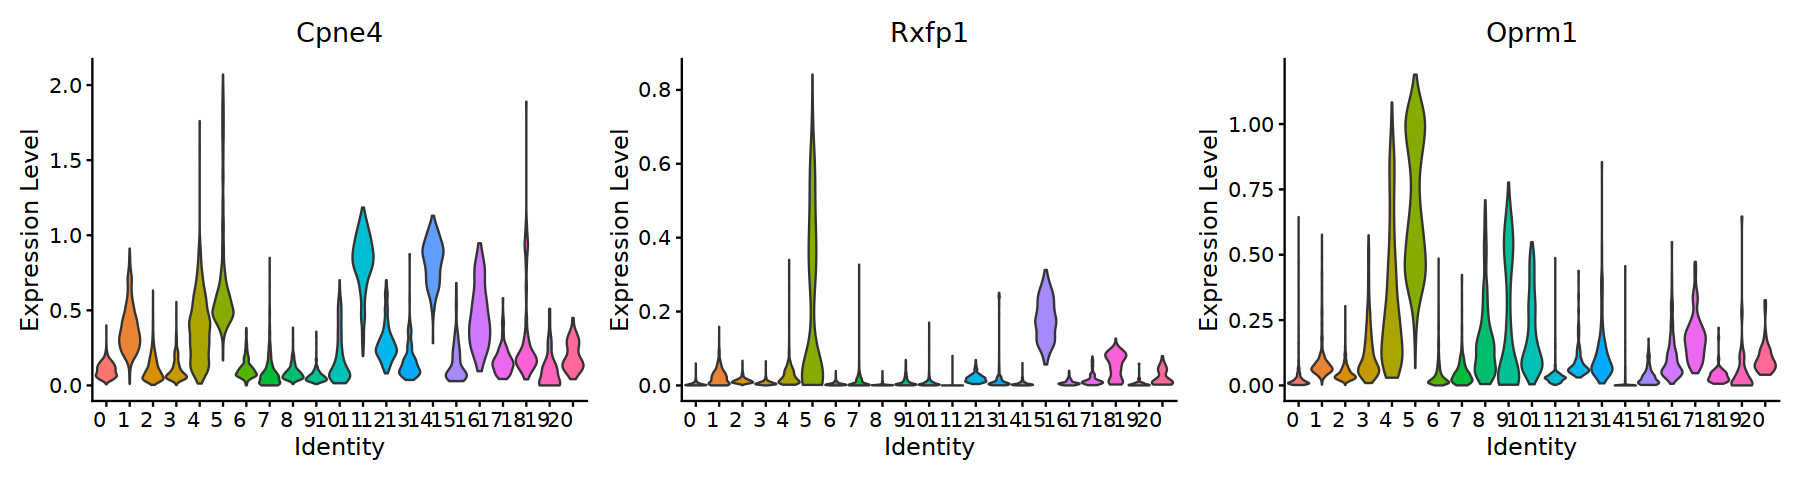

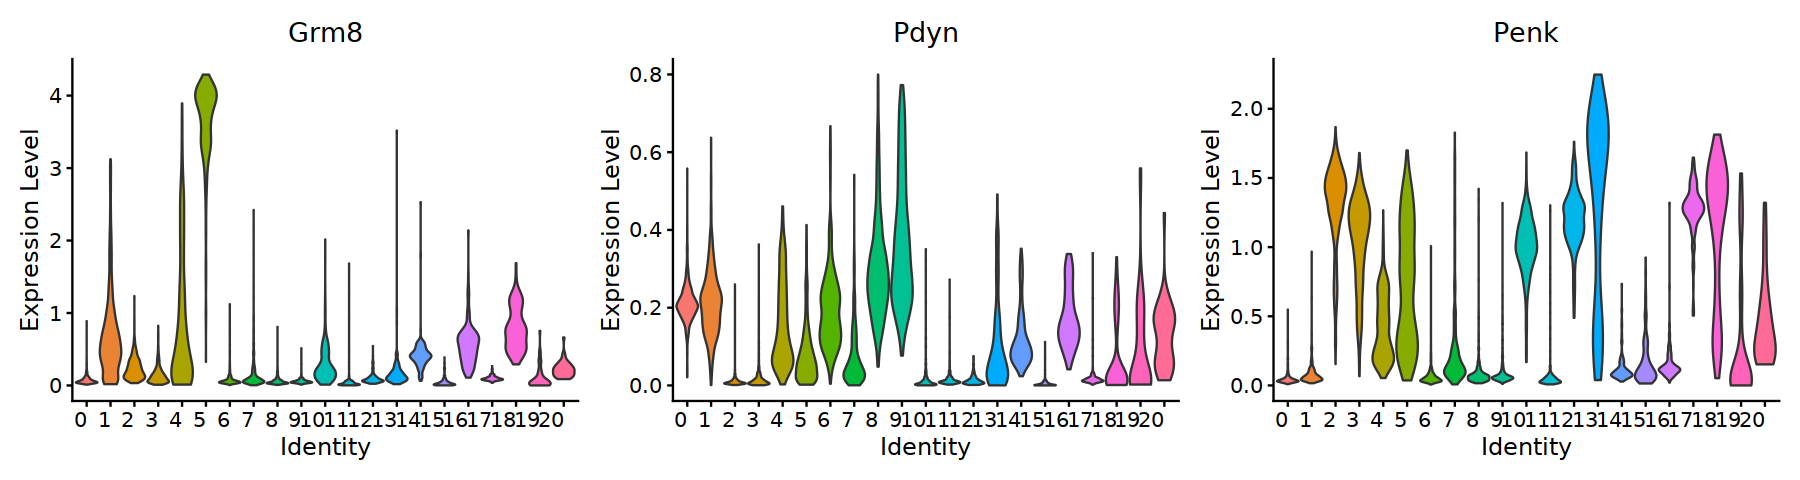

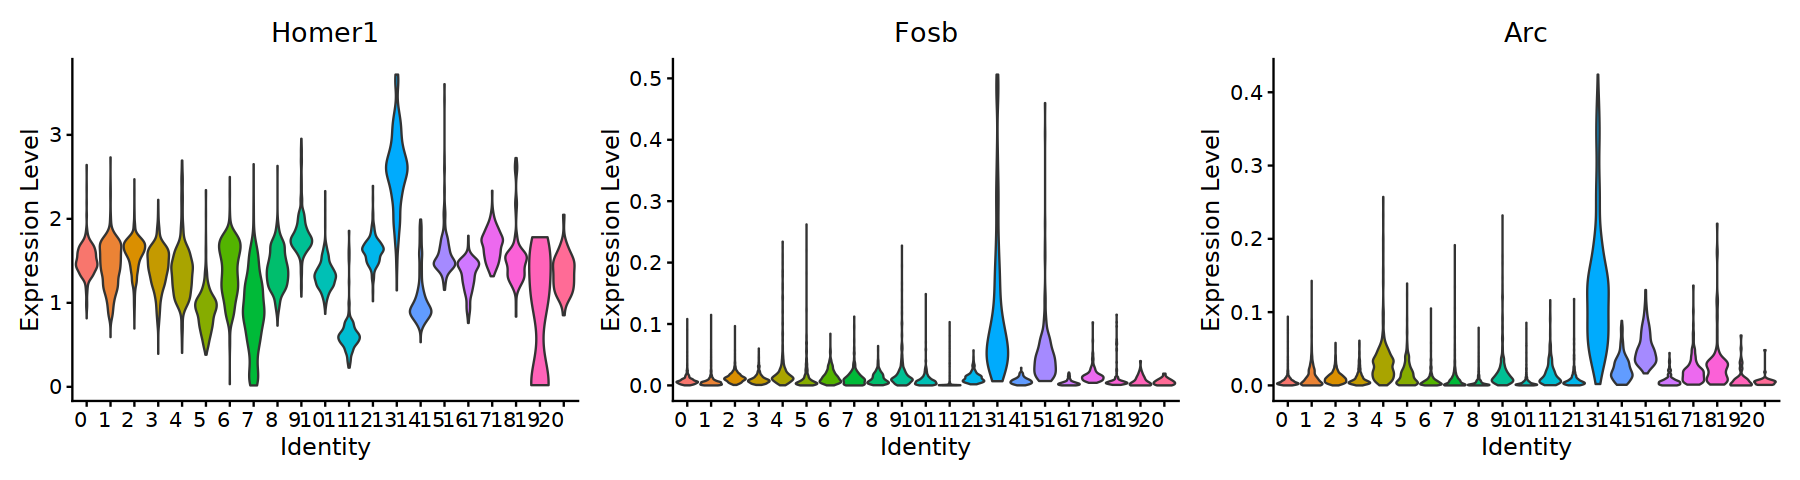

In [6]:
options(repr.plot.width=15, repr.plot.height=4)
my_theme = theme(axis.text.x = element_text(angle = 0))

features0 = c('Rbfox3', 'Gad1', 'Gad2')
VlnPlot(obj_msn, features = features0, group.by = 'seurat_clusters', assay = 'MAGIC_RNA', pt.size = 0) & my_theme

## marker genes of NAcc MSN subtypes based on He, Kleyman et al. Current Biology
features1 = c('Drd1', 'Drd2', 'Drd3')
VlnPlot(obj_msn, features = features1, group.by = 'seurat_clusters', assay = 'MAGIC_RNA', pt.size = 0) & my_theme

## marker genes of NAcc MSN subtypes based on He, Kleyman et al. Current Biology
features1 = c('Cpne4', 'Rxfp1', 'Oprm1')
VlnPlot(obj_msn, features = features1, group.by = 'seurat_clusters', assay = 'MAGIC_RNA', pt.size = 0) & my_theme

## marker genes of NAcc MSN subtypes based on Savell et al. Sci Advances 2020
features2 = c('Grm8', 'Pdyn', 'Penk')
VlnPlot(obj_msn, features = features2, group.by = 'seurat_clusters', assay = 'MAGIC_RNA', pt.size = 0) & my_theme

## Savell et al. Sci Advances 2020, enhanced experimental signal (cocaine exposure)
features2 = c('Homer1', 'Fosb', 'Arc')
VlnPlot(obj_msn, features = features2, group.by = 'seurat_clusters', assay = 'MAGIC_RNA', pt.size = 0) & my_theme

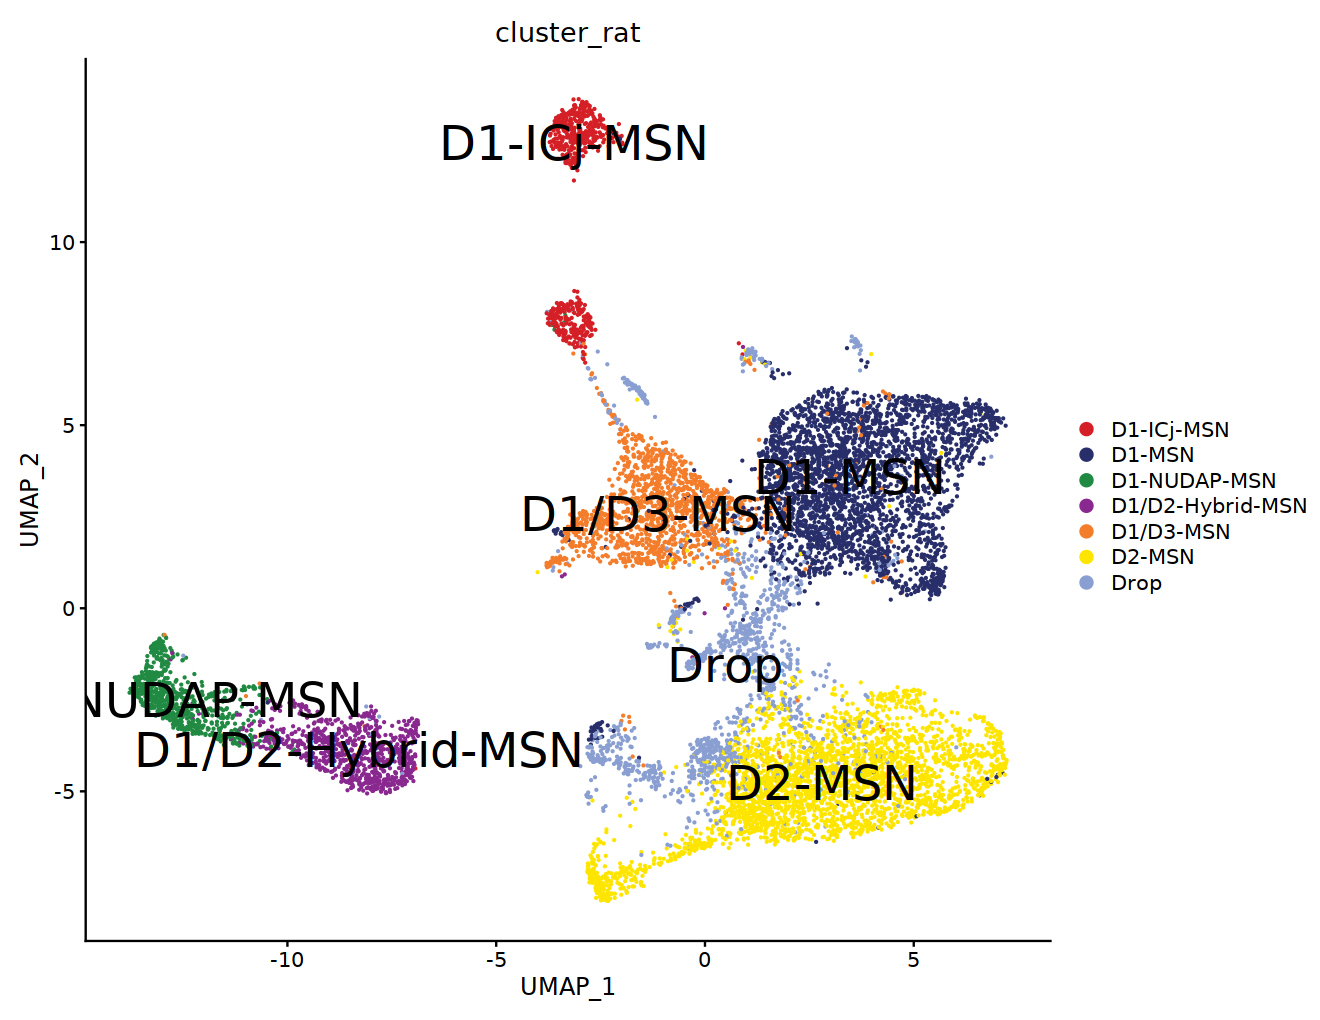

In [7]:
## using the UMAP embedding and majority clusters, relabel the MSN subtypes
obj_msn@meta.data$cluster_rat = obj_msn$celltype2

## the bad clusters
obj_msn@meta.data$cluster_rat[obj_msn$seurat_clusters %in% c(7, 12, 13, 18, 19, 20)] = 'Drop'

## canonical medium spiny neurons
obj_msn@meta.data$cluster_rat[obj_msn$seurat_clusters %in% c(0,  6, 8, 9)] = 'D1-MSN'
obj_msn@meta.data$cluster_rat[obj_msn$seurat_clusters %in% c(2, 3, 10, 15, 17)] = 'D2-MSN'
obj_msn@meta.data$cluster_rat[obj_msn$seurat_clusters %in% c(1, 16)] = 'D1/D3-MSN'

## NUDAP, D1/D2-Hybrid, ICj neurons
obj_msn@meta.data$cluster_rat[obj_msn$seurat_clusters %in% c(5)] = 'D1-NUDAP-MSN'
obj_msn@meta.data$cluster_rat[obj_msn$seurat_clusters %in% c(4)] = 'D1/D2-Hybrid-MSN'
obj_msn@meta.data$cluster_rat[obj_msn$seurat_clusters %in% c(11, 14)] = 'D1-ICj-MSN'

## visualize the cluster assignments
options(repr.plot.width=11, repr.plot.height=8.5)
DimPlot(obj_msn, reduction = "umap", group.by = "cluster_rat", label = TRUE, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_msn$cluster_rat)))

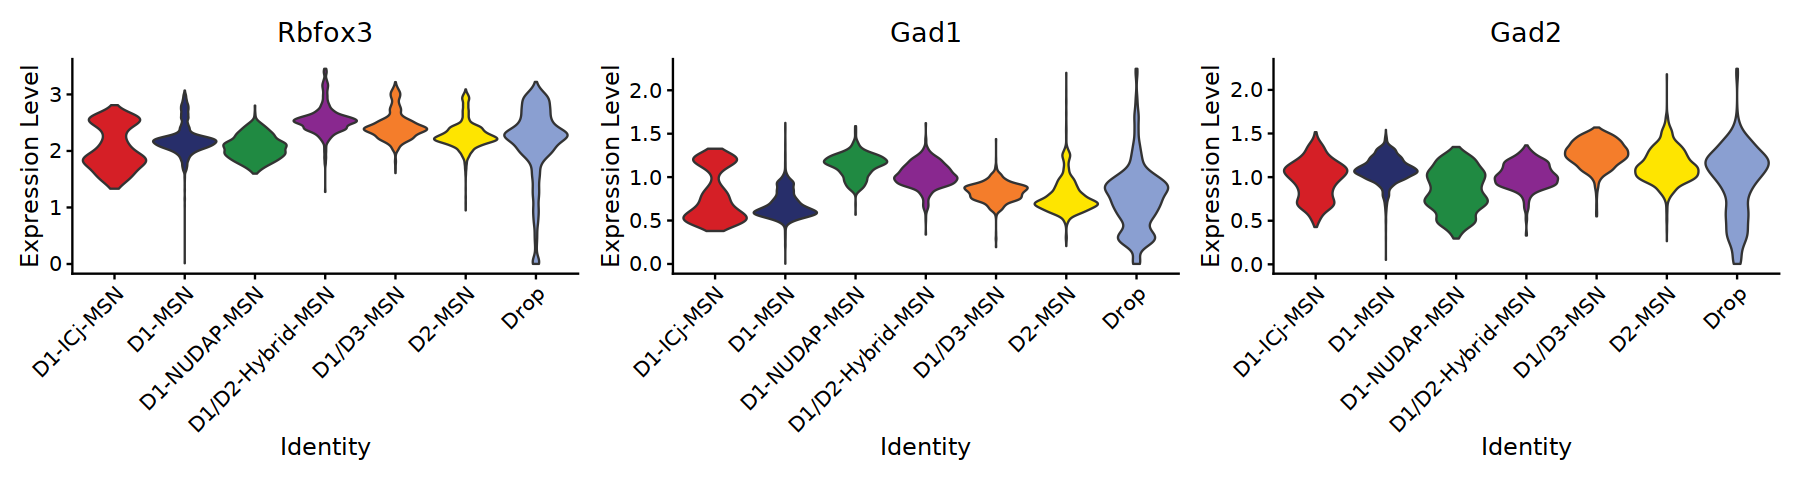

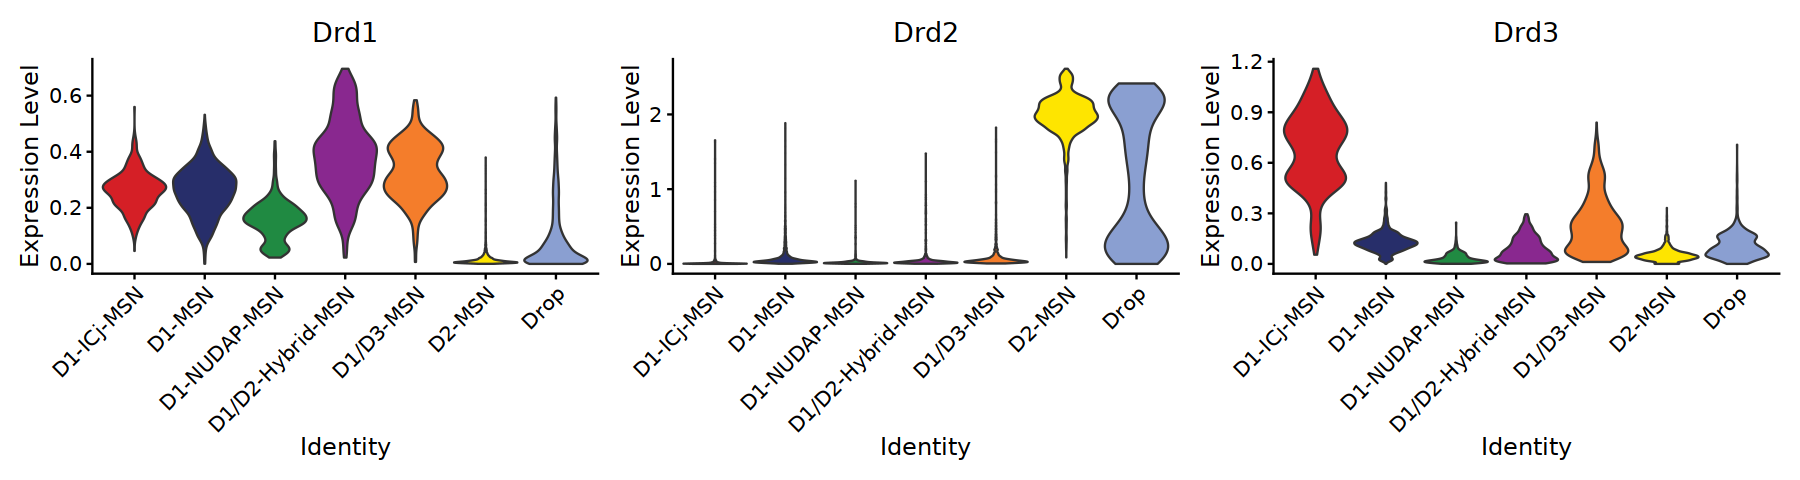

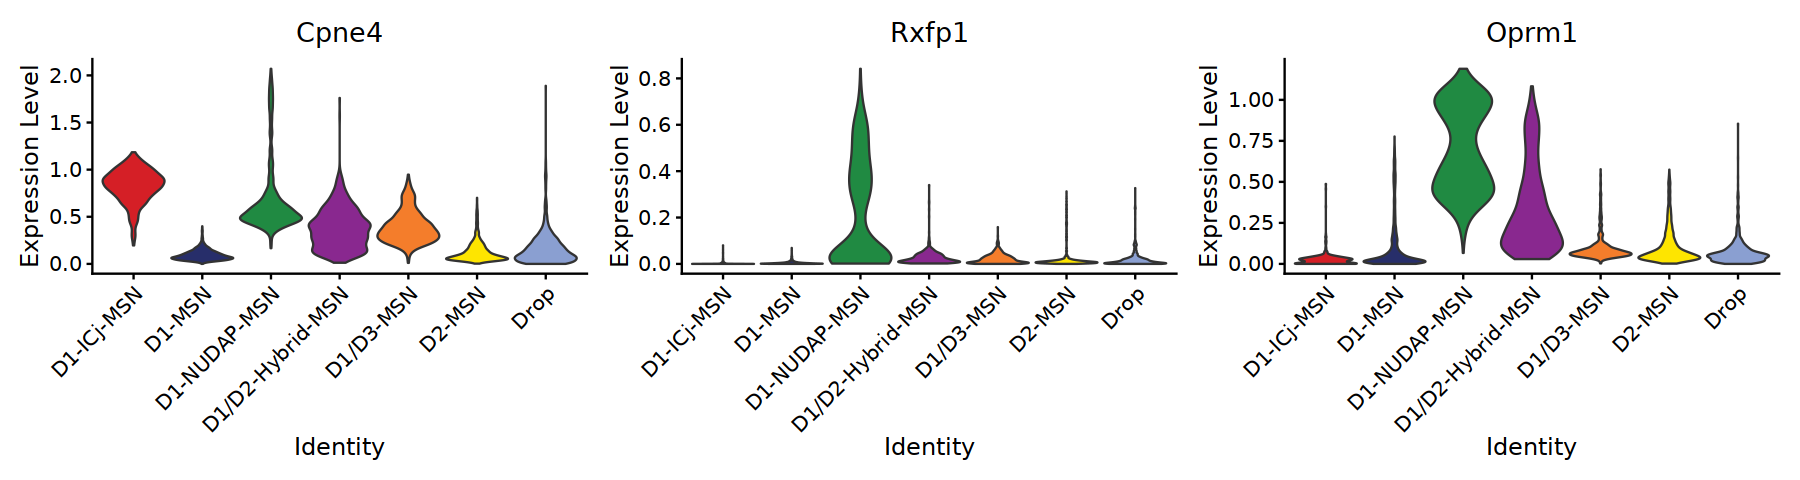

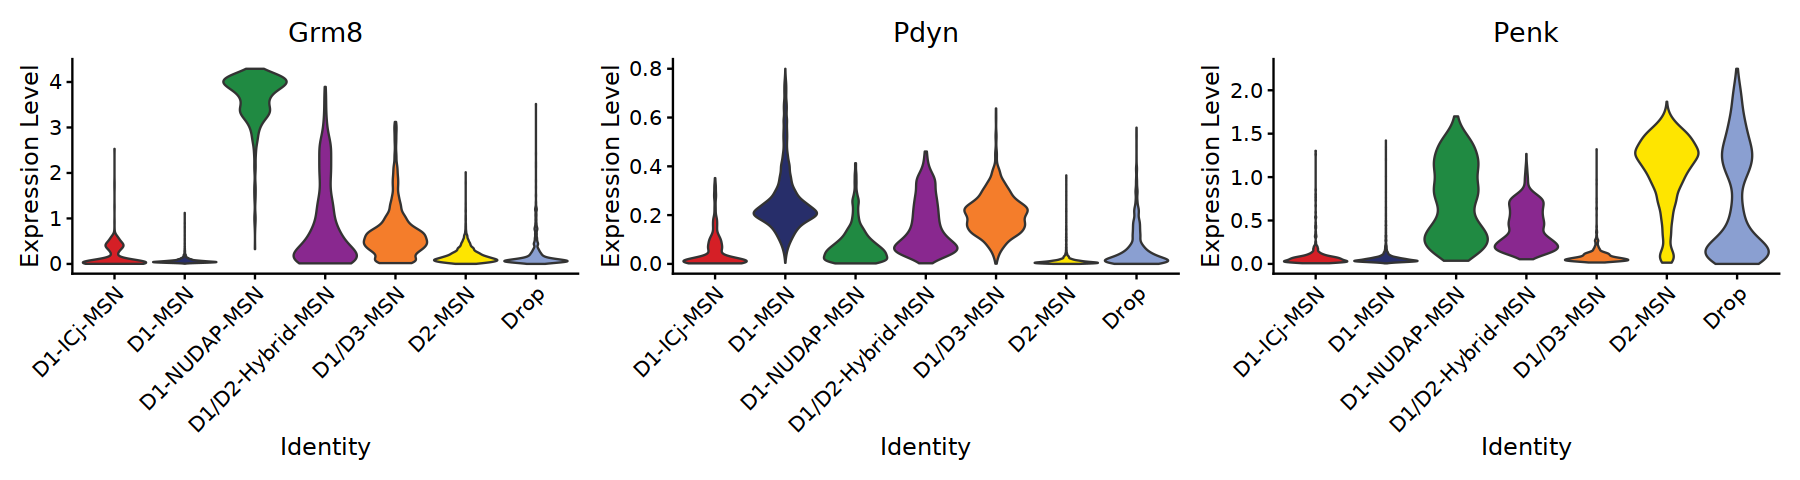

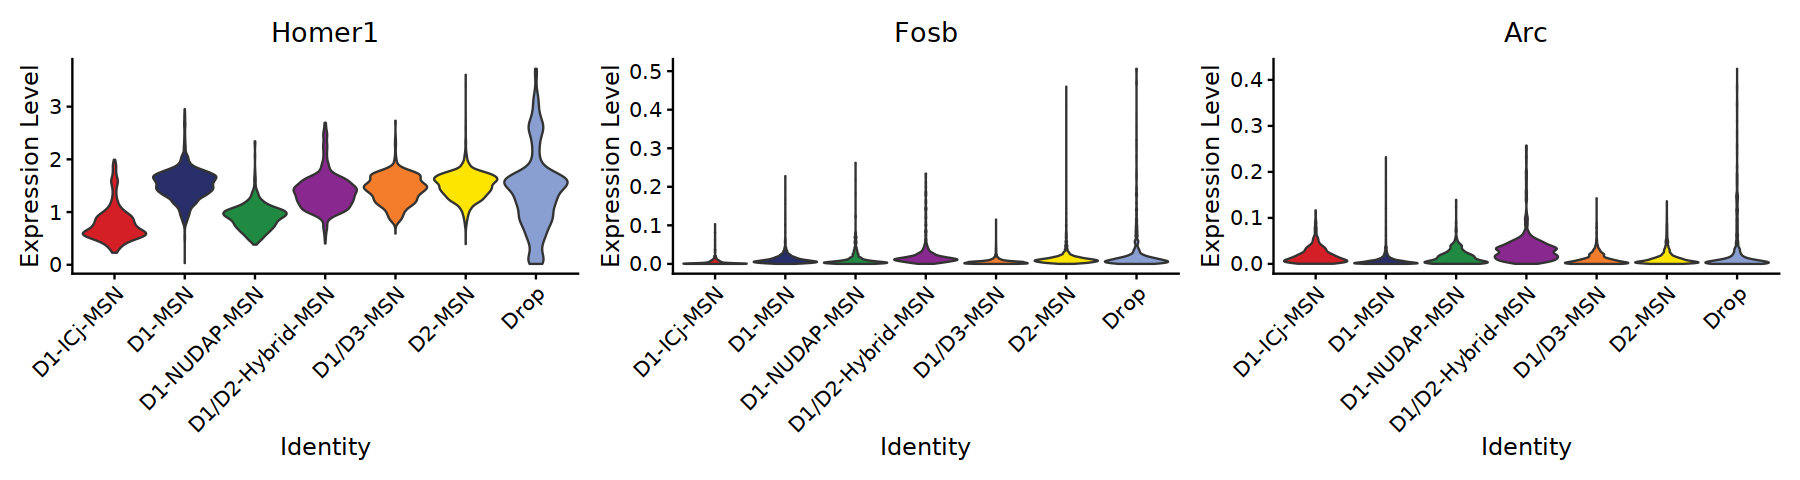

In [8]:
options(repr.plot.width=15, repr.plot.height=4)

features0 = c('Rbfox3', 'Gad1', 'Gad2')
VlnPlot(obj_msn, features = features0, group.by = 'cluster_rat', assay = 'MAGIC_RNA', pt.size = 0, 
       col = ArchR::paletteDiscrete(unique(obj_msn$cluster_rat)))

## marker genes of NAcc MSN subtypes based on He, Kleyman et al. Current Biology
features1 = c('Drd1', 'Drd2', 'Drd3')
VlnPlot(obj_msn, features = features1, group.by = 'cluster_rat', assay = 'MAGIC_RNA', pt.size = 0, 
       col = ArchR::paletteDiscrete(unique(obj_msn$cluster_rat)))

## marker genes of NAcc MSN subtypes based on He, Kleyman et al. Current Biology
features1 = c('Cpne4', 'Rxfp1', 'Oprm1')
VlnPlot(obj_msn, features = features1, group.by = 'cluster_rat', assay = 'MAGIC_RNA', pt.size = 0, 
       col = ArchR::paletteDiscrete(unique(obj_msn$cluster_rat)))

## marker genes of NAcc MSN subtypes based on Savell et al. Sci Advances 2020
features2 = c('Grm8', 'Pdyn', 'Penk')
VlnPlot(obj_msn, features = features2, group.by = 'cluster_rat', assay = 'MAGIC_RNA', pt.size = 0, 
       col = ArchR::paletteDiscrete(unique(obj_msn$cluster_rat)))

## Savell et al. Sci Advances 2020, enhanced experimental signal (cocaine exposure)
features2 = c('Homer1', 'Fosb', 'Arc')
VlnPlot(obj_msn, features = features2, group.by = 'cluster_rat', assay = 'MAGIC_RNA', pt.size = 0, 
       col = ArchR::paletteDiscrete(unique(obj_msn$cluster_rat)))

In [9]:
##################################
# 3) Refine the remaining labels

## redo the clustering for the full data
obj_merged <- obj_merged %>% FindClusters(resolution = 1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21585
Number of edges: 743553

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8929
Number of communities: 26
Elapsed time: 4 seconds


Length of unique values greater than palette, interpolating..



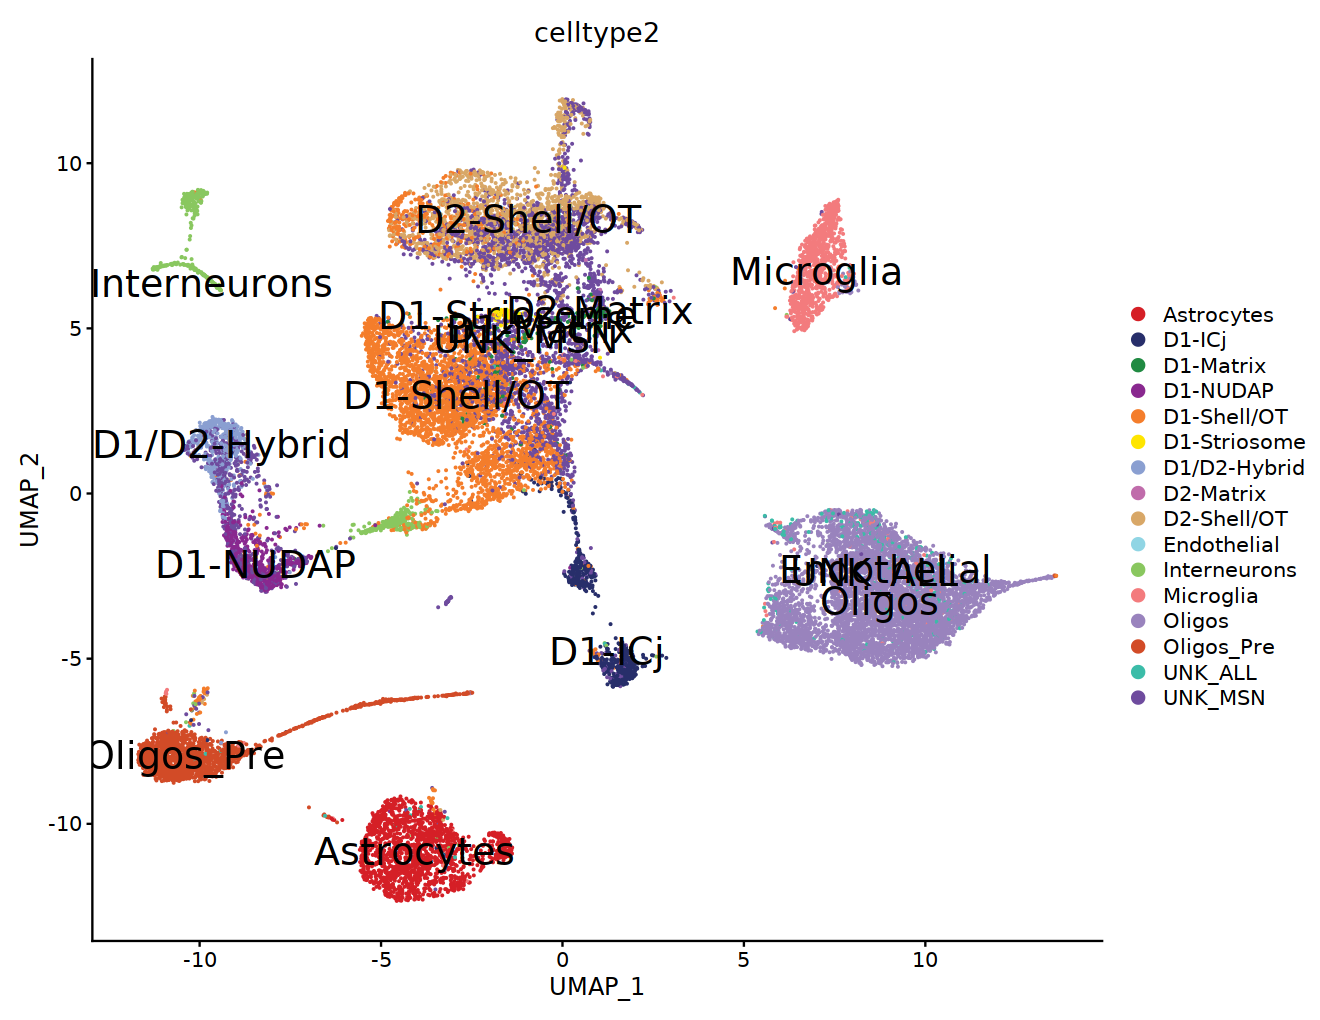

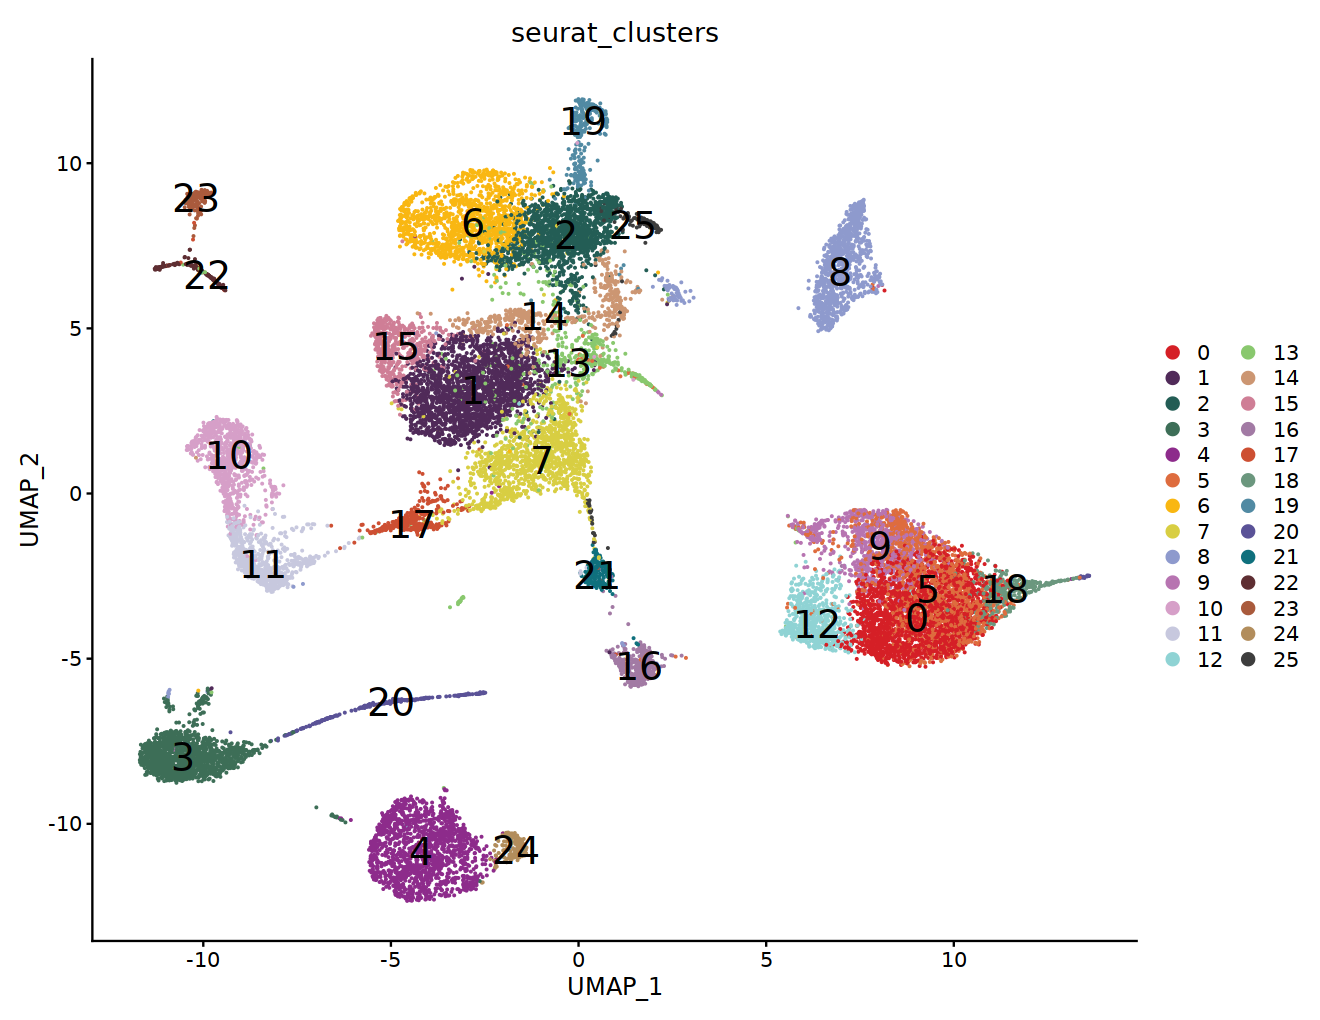

In [10]:
## plot the full dataset
options(repr.plot.width=11, repr.plot.height=8.5)
DimPlot(obj_merged, reduction = "umap", group.by = "celltype2", label = TRUE, label.size = 8, 
                cols = ArchR::paletteDiscrete(unique(obj_merged$celltype2)))
DimPlot(obj_merged, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 8, 
        cols = ArchR::paletteDiscrete(unique(obj_merged$seurat_clusters)))

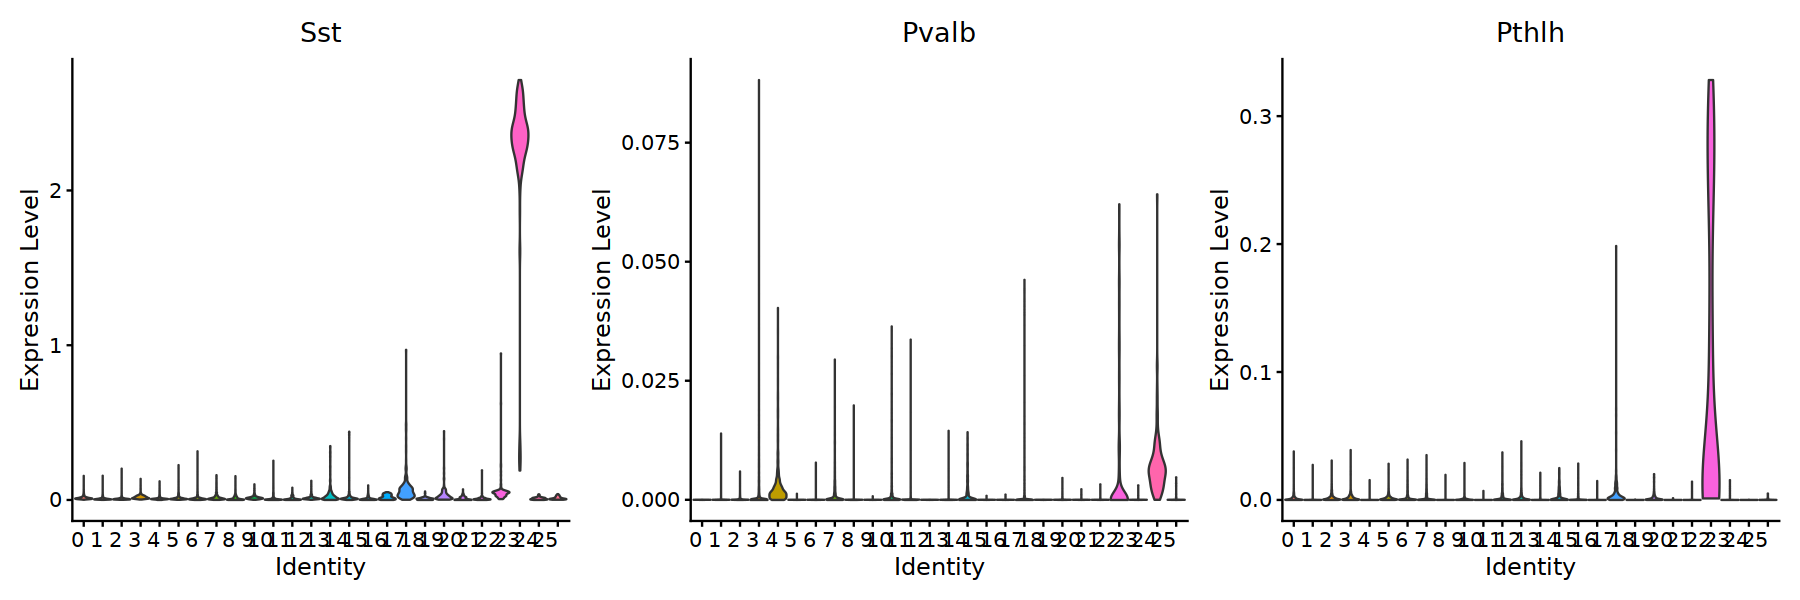

In [11]:
## Savell et al. Sci Advances 2020 found interneuron clusters, Pthlh better striatal marker of "Pvalb" interneurons
options(repr.plot.width=15, repr.plot.height=5)

features2 = c('Sst', 'Pvalb', 'Pthlh')
VlnPlot(obj_merged, features = features2, group.by = 'seurat_clusters', assay = 'MAGIC_RNA', pt.size = 0) & my_theme

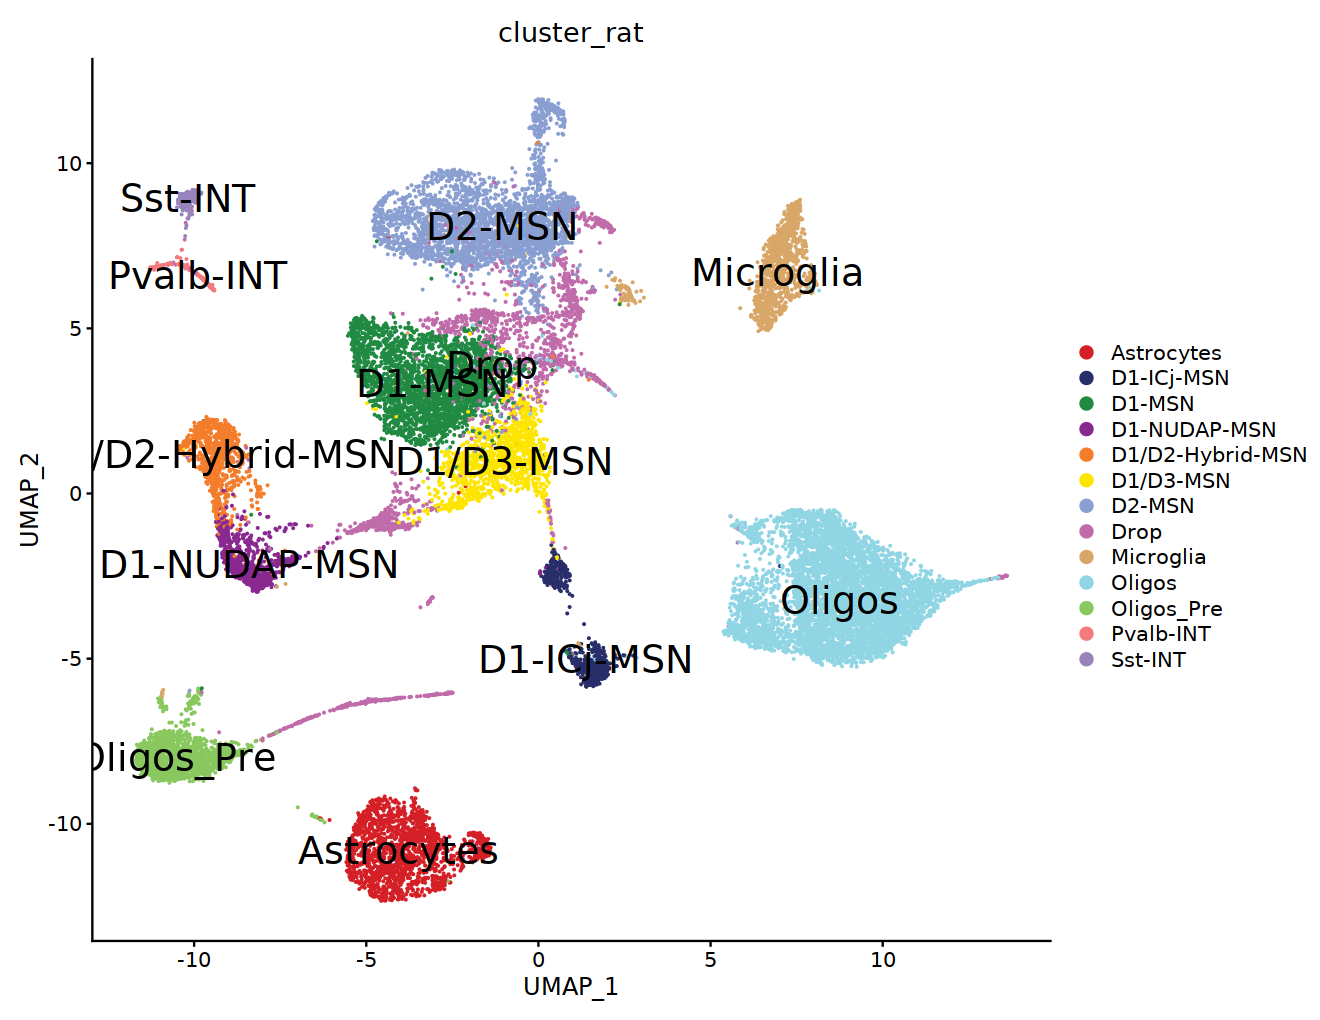

In [12]:
## using the UMAP embedding and majority clusters, relabel the rest of the cell types
obj_merged@meta.data$cluster_rat = obj_merged$celltype2

## the medium spiny neurons
obj_merged@meta.data$cluster_rat = obj_msn[['cluster_rat']][colnames(obj_merged),]
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(22, 23)] = 'Interneurons'
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(17)] = 'D1/D3-MSN' ## save this cluster
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(2, 6, 19, 25)] = 'D2-MSN' ## fix this cluster
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(1, 13, 15)] = 'D1-MSN' ## fix this cluster

## the interneurons
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(22)] = 'Pvalb-INT'
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(23)] = 'Sst-INT'

# ## the glia
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(4, 24)] = 'Astrocytes'
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(0,5,9,12,18)] = 'Oligos'
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(3)] = 'Oligos_Pre'
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(8)] = 'Microglia'

## the bad clusters
obj_merged@meta.data$cluster_rat[obj_merged$seurat_clusters %in% c(13, 14, 17, 20, 25)] = 'Drop'
obj_merged@meta.data$cluster_rat[is.na(obj_merged@meta.data$cluster_rat)] = 'Drop'

## visualize the cluster assignments
options(repr.plot.width=11, repr.plot.height=8.5)
DimPlot(obj_merged, reduction = "umap", group.by = "cluster_rat", label = TRUE, label.size = 8, 
                cols = ArchR::paletteDiscrete(unique(obj_merged$cluster_rat)))

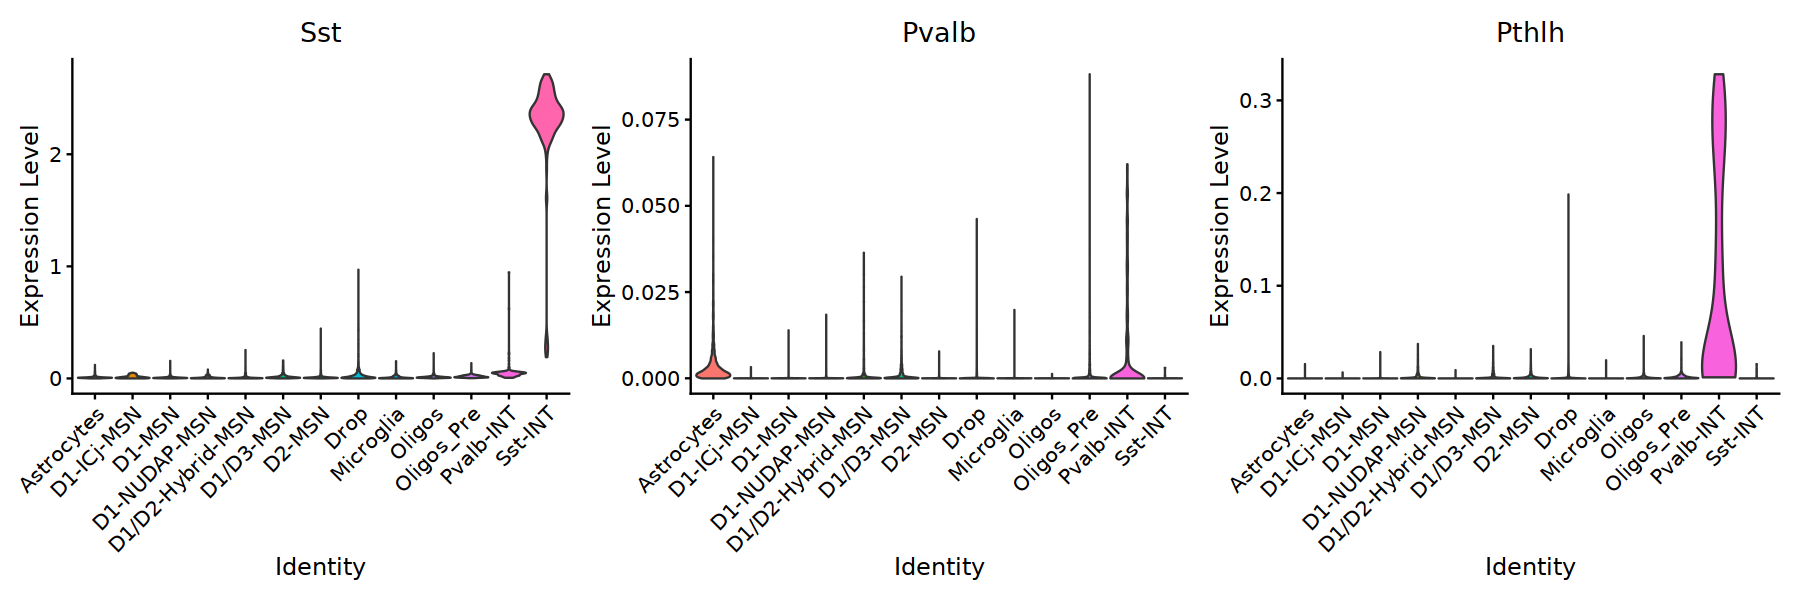

In [13]:
## Savell et al. Sci Advances 2020, enhanced experimental signal (cocaine exposure)
options(repr.plot.width=15, repr.plot.height=5)

features2 = c('Sst', 'Pvalb', 'Pthlh')
VlnPlot(obj_merged, features = features2, group.by = 'cluster_rat', assay = 'MAGIC_RNA', pt.size = 0)

In [14]:
## drop the faulty clusters
obj_merged = obj_merged %>% 
    subset(subset = cluster_rat != 'Drop') %>% 
    RunPCA(verbose = FALSE) %>% 
    FindNeighbors(dims = 1:30, verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [31]:
df_meta = obj_merged[[]] %>% 
    ## make naming convention consistent across datasets
    mutate(celltype2 = celltype2 %>% as.character() %>% str_replace_all('/OT', '') %>% make.names(), 
           celltype2 = ifelse(celltype2=='Astrocytes', 'Astro',
                       ifelse(celltype2 =='Oligos', 'Oligo', 
                       ifelse(celltype2 =='Oligos_Pre', 'OPC', celltype2))) 
          )

## create relabeling vector
table(df_meta$celltype2, df_meta$cluster_rat)
tbl = with(df_meta %>% filter(!celltype2 %in% c('UNK_ALL', 'UNK_MSN', 'D1-Striosome')), 
           table(celltype2, cluster_rat))
(rat2mac = setNames(rownames(tbl)[apply(tbl, 2, which.max)], colnames(tbl)))

              
               Astrocytes D1-ICj-MSN D1-MSN D1-NUDAP-MSN D1/D2-Hybrid-MSN
  Astro              1628          0      0            0                0
  D1.D2.Hybrid          0          1      0            6              430
  D1.ICj                2        550      0            3                3
  D1.Matrix             0          0     46            2                0
  D1.NUDAP              1          1      0          510               18
  D1.Shell             20         11   2220           22               10
  D1.Striosome          0          0      3            0                0
  D2.Shell              3          0      0            0                0
  Endothelial           0          0      0            0                0
  Interneurons          4          0      0            0                0
  Microglia             4          0      0            0                0
  Oligo                 1          0      0            0                0
  OPC                  

Astrocytes       D1-ICj-MSN           D1-MSN     D1-NUDAP-MSN 
         "Astro"         "D1.ICj"       "D1.Shell"       "D1.NUDAP" 
D1/D2-Hybrid-MSN        D1/D3-MSN           D2-MSN        Microglia 
  "D1.D2.Hybrid"       "D1.Shell"       "D2.Shell"      "Microglia" 
          Oligos       Oligos_Pre        Pvalb-INT          Sst-INT 
         "Oligo"            "OPC"   "Interneurons"   "Interneurons"

In [32]:
## perform relabeling
obj_merged@meta.data$cluster_macaque = rat2mac[obj_merged$cluster_rat]
table(obj_merged$cluster_rat)
table(obj_merged$cluster_macaque)


      Astrocytes       D1-ICj-MSN           D1-MSN     D1-NUDAP-MSN 
            1679              616             2748              719 
D1/D2-Hybrid-MSN        D1/D3-MSN           D2-MSN        Microglia 
             803             1206             3228             1064 
          Oligos       Oligos_Pre        Pvalb-INT          Sst-INT 
            5717             1557              193              173 


       Astro D1.D2.Hybrid       D1.ICj     D1.NUDAP     D1.Shell     D2.Shell 
        1679          803          616          719         3954         3228 
Interneurons    Microglia        Oligo          OPC 
         366         1064         5717         1557 

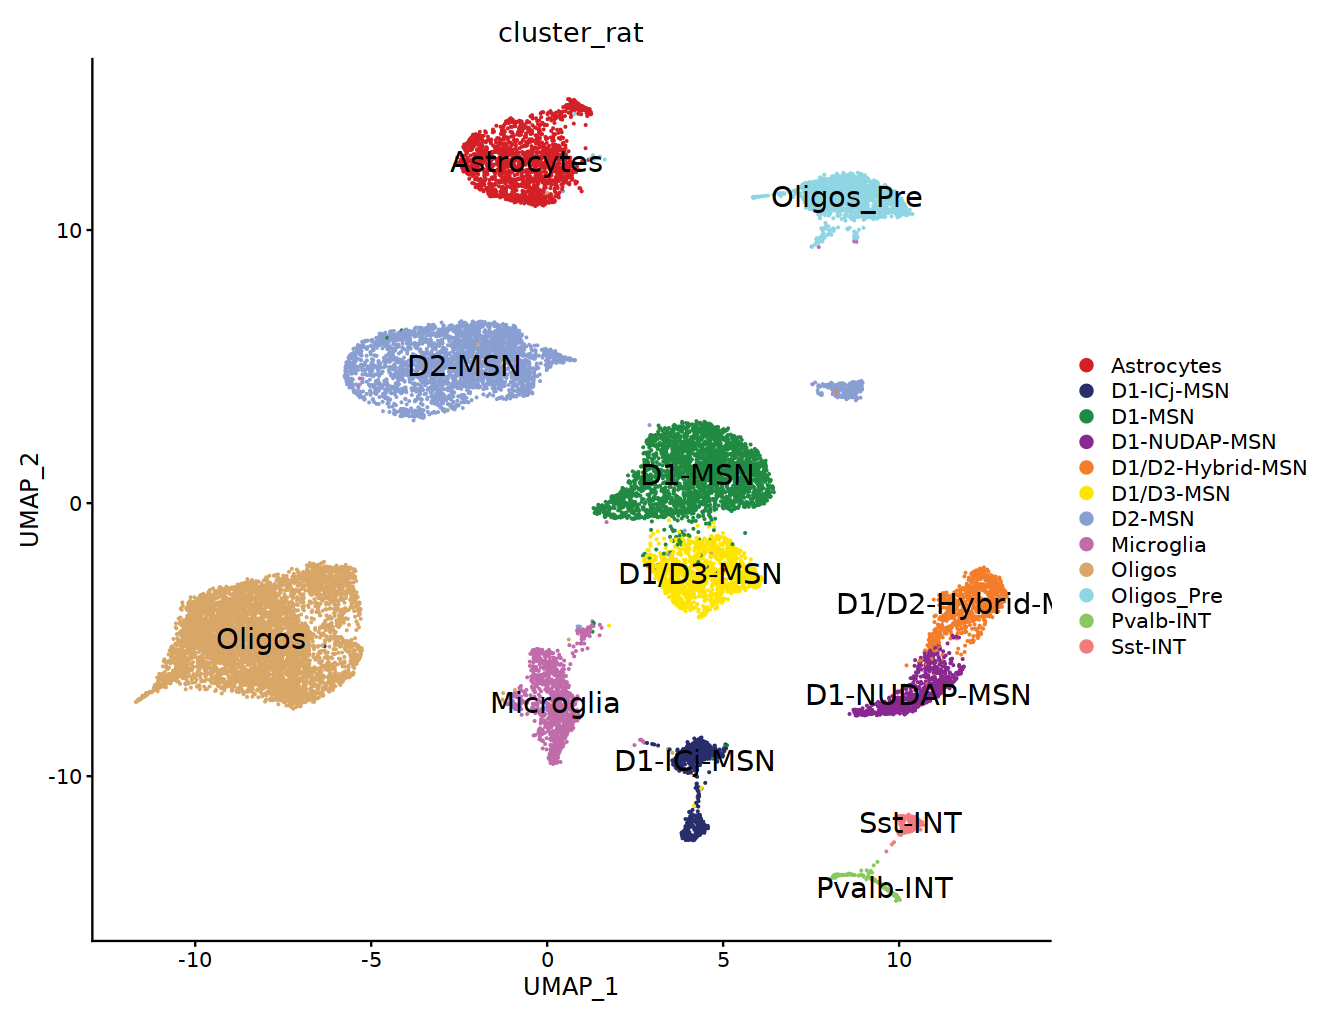

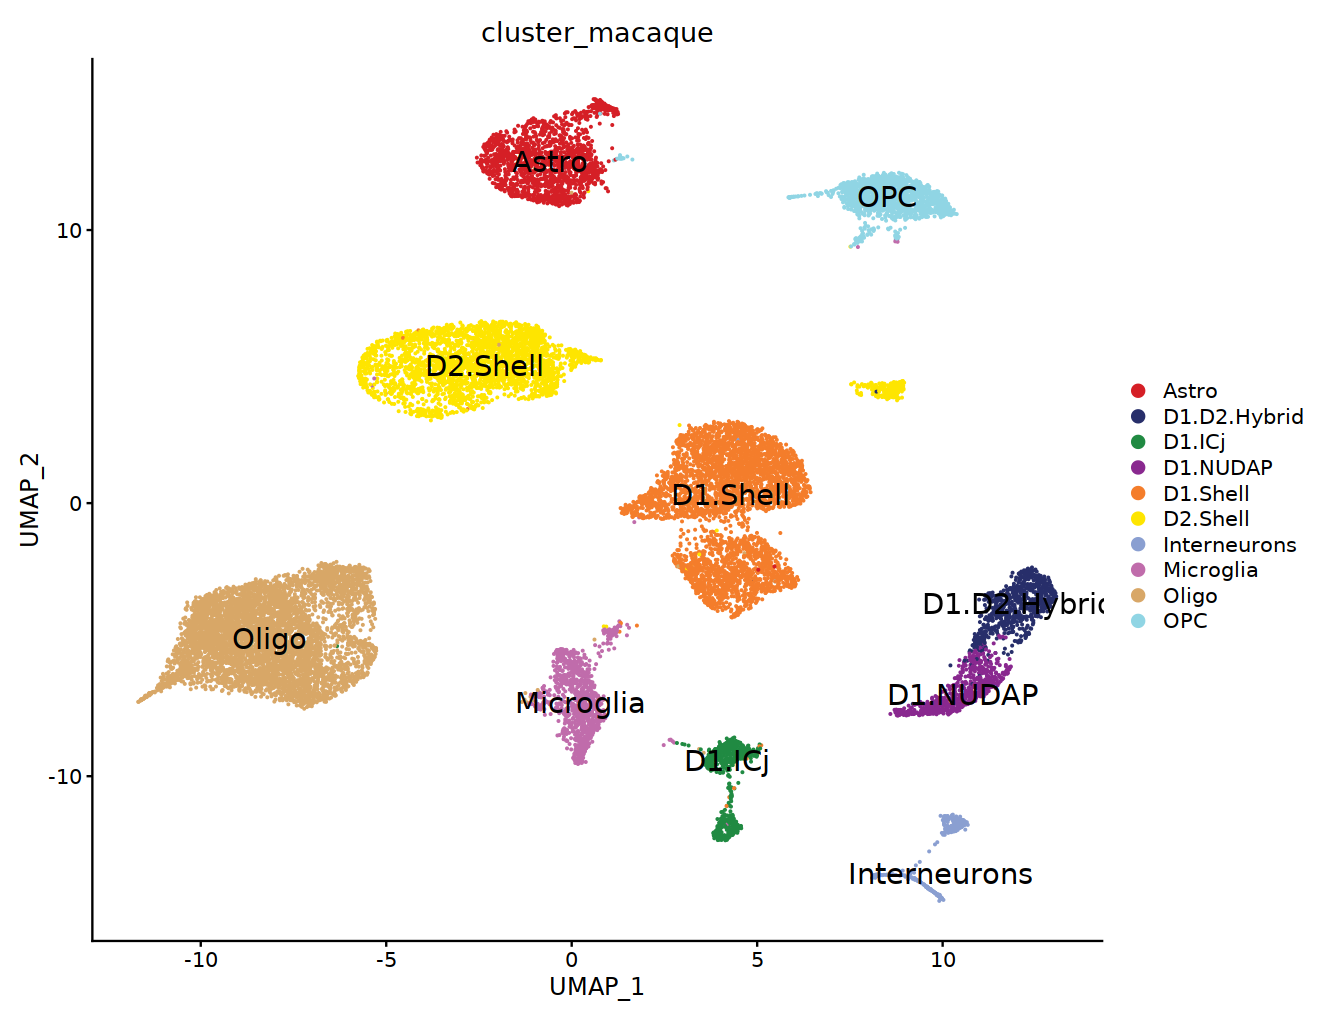

In [33]:
## visualize the refined cluster assignments w/ interneuron subtypes
options(repr.plot.width=11, repr.plot.height=8.5)

## show the rat label annotations
DimPlot(obj_merged, reduction = "umap", group.by = "cluster_rat", label = TRUE, label.size =6, 
        cols = ArchR::paletteDiscrete(unique(obj_merged$cluster_rat)))

## show the macaque label annotations
DimPlot(obj_merged, reduction = "umap", group.by = "cluster_macaque", label = TRUE, label.size =6, 
        cols = ArchR::paletteDiscrete(unique(obj_merged$cluster_macaque)))

In [34]:
obj_msn = obj_merged[,grepl('MSN', obj_merged$cluster_rat)] %>% 
    RunPCA(verbose = FALSE) %>% 
    FindNeighbors(dims = 1:30, verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)


      D1-ICj-MSN           D1-MSN     D1-NUDAP-MSN D1/D2-Hybrid-MSN 
             616             2748              719              803 
       D1/D3-MSN           D2-MSN 
            1206             3228 

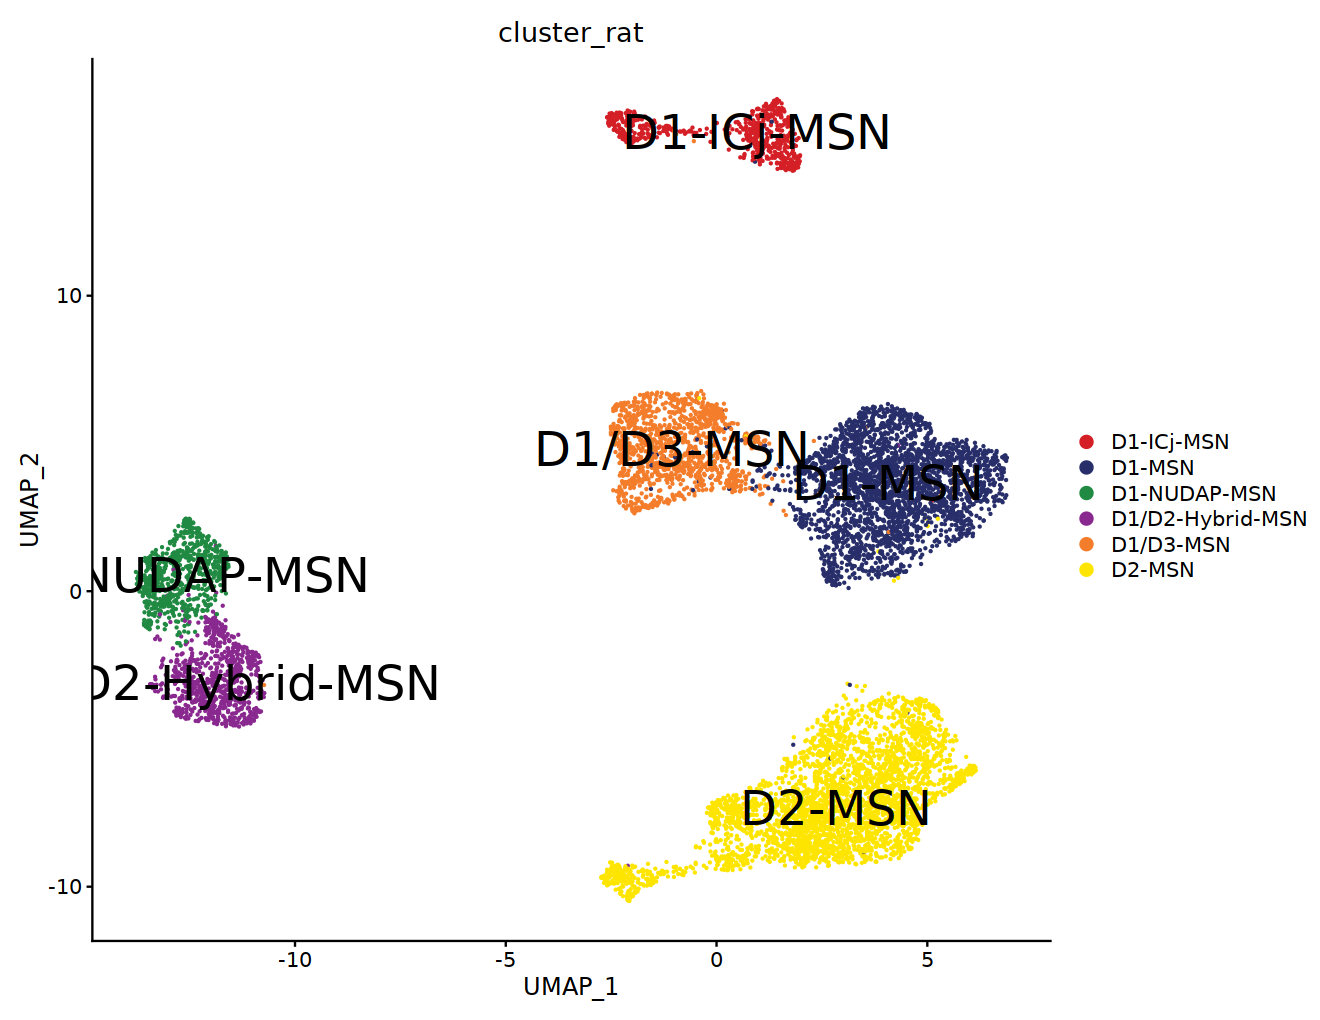

In [35]:
## visualize the refined cluster assignments
table(obj_msn$cluster_rat)
DimPlot(obj_msn, reduction = "umap", group.by = "cluster_rat", label = TRUE, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_msn$cluster_rat)))

In [36]:
################################
# 6) save the refined clusters

## export the metadata
save_meta_fn = here('data/tidy_data/tables',"Rat_transgen_multiomeRNA_refined_all_SeuratObj_N5.txt.gz")
write_tsv(obj_merged@meta.data, save_meta_fn)

## save in the MSN dataset for label refinement
save_subset_msn = here('data/tidy_data/Seurat_projects', 
                        "Rat_transgen_multiomeRNA_refined_msn_SeuratObj_N5.h5Seurat")
SaveH5Seurat(obj_msn, filename = save_subset_msn, overwrite = TRUE)

## save in the full dataset for label refinement
save_merged_fn = here('data/tidy_data/Seurat_projects', 
                        "Rat_transgen_multiomeRNA_refined_all_SeuratObj_N5.h5Seurat")
SaveH5Seurat(obj_merged, filename = save_merged_fn, overwrite = TRUE)

Warning message:
“Overwriting previous file /projects/pfenninggroup/singleCell/Pierce_transgen_rat_multiome/data/tidy_data/Seurat_projects/Rat_transgen_multiomeRNA_refined_msn_SeuratObj_N5.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

Adding variable features for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding data for MAGIC_RNA

No variable features found for MAGIC_RNA

No feature-level metadata found for MAGIC_RNA

Adding data for MAGIC_SCT

No variable features found for MAGIC_SCT

No feature-level metadata found for MAGIC_SCT

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding cell embeddings for harmony

Adding loadings for harmony

Adding projected loadings for harmony

Adding standard deviations for harmony

No JackStraw data for harmony

Adding cell embeddings for pca

Adding loadin